In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy import linalg

### Constants

In [38]:
# Mass
m = 0.044

# Principle moments of inertia
J_y = 1.60e-05
J_x = 1.60e-05
J_z = 1.60e-05
J_in1 = sym.diag(J_x, J_y, J_z)


# Acceleration of gravity
g = 9.81

# # Pendulum parameters
l_pen = 500e-3 # maybe m
m_pen = 0.006

In [39]:
def Rotate(alpha, beta, gamma):
    Rz = sym.Matrix([[sym.cos(alpha), -sym.sin(alpha), 0],
                 [sym.sin(alpha), sym.cos(alpha), 0],
                 [0, 0, 1]])

    Ry = sym.Matrix([[sym.cos(beta), 0, sym.sin(beta)],
                 [0, 1, 0],
                 [-sym.sin(beta), 0, sym.cos(beta)]])

    Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(gamma), -sym.sin(gamma)],
                 [0, sym.sin(gamma), sym.cos(gamma)]])

    R_VtoO = Rz * Ry * Rx

    return R_VtoO

def N_func(alpha, beta, gamma):
    Ninv = sym.Matrix([[sym.cos(beta)*sym.cos(gamma), -sym.sin(gamma), 0],
                       [sym.cos(beta)*sym.sin(gamma), sym.cos(gamma), 0],
                       [-sym.sin(beta), 0, 1]])

    # N = sym.simplify(Ninv.inv())
    N = Ninv.inv()
    return N

### State Derivative

Calculates the derivative of the state.

In [40]:
def propogate_state(state, inputs):
    # state: [o_x, o_x_dot, o_y, o_y_dot, o_z, o_z_dot, alpha, beta, gamma, wx, wy, wz, r, s, rdot, sdot]
    # inputs: [tau_x, tau_y, tau_z, f_z]
    Rotation_matrix = Rotate(state[6], state[7], state[8])
    N = N_func(state[6], state[7], state[8])
    second_derivatives = Rotation_matrix * sym.Matrix([0, 0, inputs[3]])/m + sym.Matrix([0, 0, -g])
    angle_derivatives = N * sym.Matrix([state[9], state[10], state[11]]) # [gamma_dot, beta_dot, alpha_dot]
    tau_in1 = sym.Matrix([inputs[0], inputs[1], inputs[2]])
    w_01in1 = sym.Matrix([state[9], state[10], state[11]])
    w_derivatives = J_in1.inv() * (tau_in1 - w_01in1.cross(J_in1 * w_01in1))
    zeta = np.sqrt(l_pen**2 - state[12]**2 - state[13]**2)
    state_dot = np.zeros(16)
    state_dot[0] = state[1]
    state_dot[1] = second_derivatives[0]
    state_dot[2] = state[3]
    state_dot[3] = second_derivatives[1]
    state_dot[4] = state[5]
    state_dot[5] = second_derivatives[2]
    state_dot[6] = angle_derivatives[2]
    state_dot[7] = angle_derivatives[1]
    state_dot[8] = angle_derivatives[0]
    state_dot[9] = w_derivatives[0]
    state_dot[10] = w_derivatives[1]
    state_dot[11] = w_derivatives[2]
    state_dot[12] = state[14]
    state_dot[13] = state[15]
    r = state[12]
    rdot = state[14]
    s = state[13]
    sdot = state[15]
    state_dot[14] = r*(g*zeta**3 - l_pen**2 * (rdot**2 + sdot**2) + (s*rdot + r*sdot)**2)/(l_pen**2 * zeta**2)
    state_dot[15] = s*(g*zeta**3 - l_pen**2 * (rdot**2 + sdot**2) + (s*rdot + r*sdot)**2)/(l_pen**2 * zeta**2)

    return state_dot

### RK4 propogator

To get the next state

In [41]:
def rk4(state, inputs, delta_t):
    y1 = propogate_state(state, inputs)
    y2 = propogate_state(state + 1/2*delta_t*y1, inputs)
    y3 = propogate_state(state + 1/2*delta_t*y2, inputs)
    y4 = propogate_state(state + delta_t*y3, inputs)

    return state + 1/6 * delta_t *(y1 + 2*y2 + 2*y3 + y4)


### Controller

To calculate the inputs based on the current state. The K values are from the `planar_problem_state_space.ipynb` notebook.

In [42]:
def controller(state, state_des):
    K = np.array([[ 2.29068471e-16,  8.61099641e-17, -1.00000000e-03,
        -1.46692707e-03, -6.36702352e-17, -3.27759827e-17,
         6.12447355e-17,  1.40711930e-16,  5.64994698e-03,
         1.08508448e-03,  2.29866193e-18, -1.00623396e-17, 0., 0., 0., 0.],
       [ 1.00000000e-03,  1.46721568e-03, -2.93169827e-18,
        -5.02334439e-18,  1.70125278e-19,  8.06174118e-19,
        -1.17249228e-18,  5.65410069e-03,  2.27241353e-17,
         2.25556202e-18,  1.08670659e-03, -6.71701600e-21, 0., 0., 0., 0.],
       [ 8.43653003e-19, -4.48211560e-17,  9.25125544e-17,
         8.91467135e-17, -2.28041744e-17, -1.56931322e-17,
         1.00000000e-03, -4.14902786e-18, -2.98298408e-16,
        -7.70627958e-18, -5.24254907e-21,  1.02029408e-03, 0., 0., 0., 0.],
       [ 4.48687243e-17,  1.90416935e-15,  1.74110535e-14,
         2.70758679e-14,  3.16227766e-01,  3.57530479e-01,
        -3.47289645e-14,  2.11235997e-15, -1.22078655e-13,
        -1.16950666e-15,  2.93154225e-17, -7.31157298e-16, 0., 0., 0., 0.]])
    u = -K @ (state - state_des)
    u[3] += (m)*g # Adding the equilibrium f_z value
    return u

Run the sim

In [43]:
def sim(times,inputs_data, state_data, state_des, delta_t):
    for i, time in enumerate(times):

        if i == 0:
            continue

        else:
            inputs_data[i-1] = controller(state_data[i-1], state_des)
            state_data[i] = rk4(state_data[i-1], inputs_data[i-1], delta_t)

In [44]:
# state: [o_x, o_x_dot, o_y, o_y_dot, o_z, o_z_dot, alpha, beta, gamma, wx, wy, wz]

# Set up sim
delta_t = 0.01
total_t = 10
times = np.arange(0, total_t + delta_t/2, delta_t)
inputs_data = np.zeros((len(times), 4))
state_data = np.zeros((len(times), 16))

# Desired States
state_des = np.array([0., 0., 0.0, 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
# Initial condition
state_data[0] = np.array([0.4, 0., 0.0, 0., 1.5, 0., 0., 0.0, 0., 0.1, 0.0, 0.0, 0., 0.3, 0., 0.])

# Run sim
sim(times, inputs_data, state_data, state_des, delta_t)

C:\Users\anshukc2\AppData\Local\Temp\ipykernel_13404\4127483737.py:11: RuntimeWarning: invalid value encountered in sqrt
  zeta = np.sqrt(l_pen**2 - state[12]**2 - state[13]**2)


### Plotting and animation

Text(0.5, 0, 'time (s)')

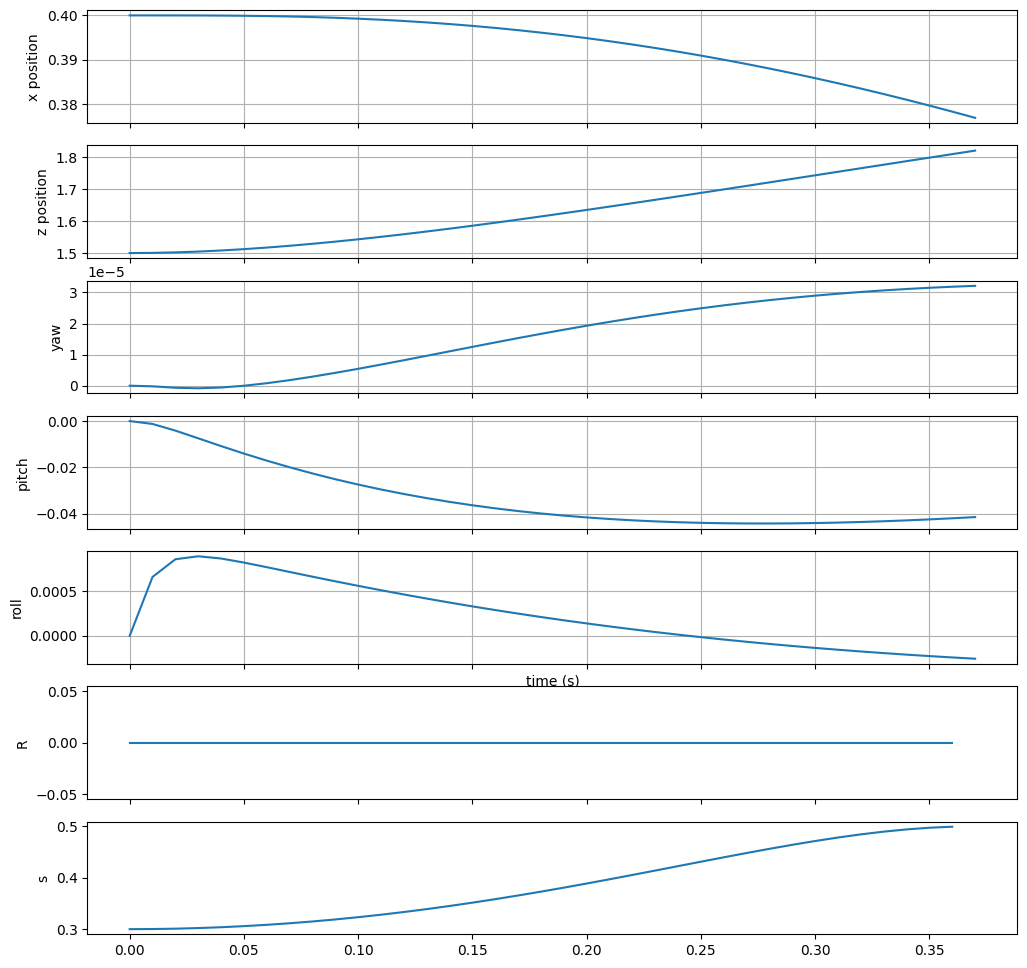

In [45]:
fig, (ax_o_x, ax_o_z, ax_alpha, ax_beta, ax_gamma, ax_r_offset, ax_s_offset) = plt.subplots(7, 1, figsize=(12, 12), sharex=True)

# state: [o_x, o_x_dot, o_y, o_y_dot, o_z, o_z_dot, alpha, beta, gamma, wx, wy, wz]

ax_o_x.plot(times, state_data[:,0])
ax_o_x.set_ylabel('x position')
ax_o_z.plot(times, state_data[:,4])
ax_o_z.set_ylabel('z position')
ax_alpha.plot(times, state_data[:,6])
ax_alpha.set_ylabel('yaw')
ax_beta.plot(times, state_data[:,7])
ax_beta.set_ylabel('pitch')
ax_gamma.plot(times, state_data[:,8])
ax_gamma.set_ylabel('roll')
ax_r_offset.plot(times, state_data[:,12])
ax_r_offset.set_ylabel('R')
ax_s_offset.plot(times, state_data[:,13])
ax_s_offset.set_ylabel('s')
ax_o_x.grid()
ax_o_z.grid()
ax_alpha.grid()
ax_beta.grid()
ax_gamma.grid()
ax_gamma.set_xlabel('time (s)')


In [36]:
print(state_data[:,15])

[0. 0. 0. ... 0. 0. 0.]


In [ ]:
fig, (ax_tau_y, ax_f_z) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

ax_tau_y.plot(times[:-1], inputs_data[:-1,0])
ax_f_z.plot(times[:-1], inputs_data[:-1,1])
ax_tau_y.set_ylabel('Pitch Torque')
ax_f_z.set_ylabel('Thrust')
ax_tau_y.grid()
ax_f_z.grid()
ax_alpha.set_xlabel('time (s)')

In [ ]:
# Write State Data and Timestamps to a csv for Animation

import os

record = []
for point in range(len(times)):
    cur_point = []
    cur_point.append(str(times[point]))
    cur_point.append(str(state_data[point, 0])) #x-pos
    cur_point.append(str(state_data[point, 2])) #z-pos
    cur_point.append(str(state_data[point, 4])) #theta
    cur_point.append(str(state_data[point,6]))  #alpha
    record.append(cur_point)
print(state_data[13, 6])
output_file = 'sim.csv'
with open(output_file, 'w') as f:
    f.write("time,x,z,theta,alpha\n")
    for point in record:
        f.write(f"{','.join(point)}\n")

### Controller Design


In [ ]:
o_x, o_y, o_z, alpha, beta, gamma, wx, wy, wz, ox_dot, oy_dot, oz_dot= sym.symbols(r'o_x o_y o_z \alpha \beta \gamma w_x w_y w_z ox_{dot} oy_{dot} oz_{dot}')
tau_x, tau_y, tau_z, f_z = sym.symbols('tau_x, tau_y, tau_z, f_z')
m, Jx, Jy, Jz = sym.symbols('m J_x J_y J_z')
J_in1 = sym.diag(Jx, Jy, Jz)
tau_in1 = sym.Matrix([tau_x, tau_y, tau_z])
w_01in1 = sym.Matrix([wx, wy, wz])
# state: [o_x, o_x_dot, o_y, o_y_dot, o_z, o_z_dot, alpha, beta, gamma, wx, wy, wz]
# inputs: [tau_x, tau_y, tau_z, f_z]
Rotation_matrix = Rotate(alpha, beta, gamma)
N = N_func(alpha, beta, gamma)
second_derivatives = Rotation_matrix * sym.Matrix([0, 0, f_z])/m + sym.Matrix([0, 0, -g])
angle_derivatives = N * sym.Matrix([wx, wy, wz]) # [gamma_dot, beta_dot, alpha_dot]
w_derivatives = J_in1.inv() * (tau_in1 - w_01in1.cross(J_in1 * w_01in1))
f_sym = sym.zeros(12,1)
f_sym[0] = ox_dot
f_sym[1] = second_derivatives[0]
f_sym[2] = oy_dot
f_sym[3] = second_derivatives[1]
f_sym[4] = oz_dot
f_sym[5] = second_derivatives[2]
f_sym[6] = angle_derivatives[2]
f_sym[7] = angle_derivatives[1]
f_sym[8] = angle_derivatives[0]
f_sym[9] = w_derivatives[0]
f_sym[10] = w_derivatives[1]
f_sym[11] = w_derivatives[2]

In [ ]:
s = [o_x, ox_dot, o_y, oy_dot, o_z, oz_dot, alpha, beta, gamma, wx, wy, wz]
i = [tau_x, tau_y, tau_z, f_z]
p = [m, Jx, Jy, Jz]

In [ ]:
f = sym.lambdify(s + i + p, f_sym)

In [ ]:
# Mass
m = 0.044

# Principle moments of inertia
J_x = 1.57e-05
J_y = 1.60e-05
J_z = 2.05e-05

# Acceleration of gravity
g = 9.81

p_eq = [m, J_x, J_y, J_z]

In [ ]:
s_eq = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
i_eq = [0., 0., 0., g*(m)]

In [ ]:
print(f(*s_eq, *i_eq, *p_eq))

In [ ]:
A_sym = f_sym.jacobian(s)
B_sym = f_sym.jacobian(i)

A_num = sym.lambdify(s + i + p, A_sym)
B_num = sym.lambdify(s + i + p, B_sym)

A = A_num(*s_eq, *i_eq, *p_eq)
B = B_num(*s_eq, *i_eq, *p_eq)

In [ ]:
A_str = np.array2string(A,
                        formatter={'float_kind': lambda x: f'{x:5.2f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'A = {A_str}')

In [ ]:
B_str = np.array2string(B,
                        formatter={'float_kind': lambda x: f'{x:10.2f}'},
                        prefix='    ',
                        max_line_width=np.inf)
B
print(f'B = {B_str}')

In [ ]:
Q = np.diag([
    1., 
    1., 
    1., 
    1., 
    1., 
    1., 
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
])

R = np.diag([
    1E6, #tau_x
    1E6,#tau_y
    1E6,
    10,
])

def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K


In [ ]:
K = lqr(A, B, Q, R)

K